This script is to evaluate the DatesNet model trained on FER+dataset. To evaluate the model, we are using KL divergence, Accuracy, Recall, F1 score, and confusion matrix. 

To give a bit of context, the model is taking FER+ dataset as input. But, in FER+ dataset, they provide votes on emotion classes per image. What it means is that for each image, we get votes on what might be the emotion for that very image. 

First we will import all the necessary packages

In [1]:
import os
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

from config.datesnet_config import Config as cfg

from lib.datesnet import DatesNet
from data.data_processing import DataProcessing
from data.dataset_loader import FERPlusDatasetLoader

First we will load the model. 

In [2]:
# Load the model
model = DatesNet(cfg=cfg)

Now, we will load the saved weights from the checkpoint. 

In [3]:
if not os.path.exists(cfg.TestConfig.checkpoint_name):
    raise FileNotFoundError(f'{cfg.TestConfig.checkpoint_name} file not found')

checkpoint = torch.load(cfg.TestConfig.checkpoint_name, map_location=cfg.device)
if 'state_dict' in checkpoint.keys():
    state_dict = checkpoint['state_dict']
else:
    raise KeyError("state_dict is not found in the checkpoint")
model.load_state_dict(state_dict=state_dict)

<All keys matched successfully>

Switch the model to evalautin modeto disable dropout and batch norm. Later we will use troech.no_grad() to prevent gradient tracking. 

In [4]:
model.eval()
model.to(cfg.device)

DatesNet(
  (encoders): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ResidualBlock(
        (layer_latent): Sequential(
          (0): GroupNorm(16, 64, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): GroupNorm(16, 64, eps=1e-05, affine=True)
          (4): SiLU()
          (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (extra_layer): Identity()
      )
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ResidualBlock(
        (layer_latent): Sequential(
          (0): GroupNorm(16, 64, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): GroupNorm(16, 128, eps=1e-05, affine=True)
          (4): SiLU()
          (5): Conv2d(128,

## Preprocess and load Test dataset
Now, we are going to pre-process and load the test dataset. We use the same preo-processing as the validation steps.
- Histogram Equalization
- Normalize (using mean and std of the training dataset)

In [5]:
# Use the mean and std computed on the FER+ dataset
mean = list([0.5015, 0.5015, 0.5015])
std = list([0.2918, 0.2918, 0.2918])

data_processor = DataProcessing(cfg)
test_transform = data_processor.get_test_transform(mean=mean, std=std)
test_dataset = FERPlusDatasetLoader(cfg=cfg, dataset_name='test', transforms=test_transform)
test_dataset_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False, num_workers=16, pin_memory=True)
class_names = test_dataset.get_labels_name()

C:\dependencies\conda3\envs\datesnet\lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
100%|███████████████████████████████████████████████████████████████████| 3589/3589 [00:00<00:00, 4084.35it/s]


## Infer model
We will infe the model with the test dataset. To simplify, we load the whole test dataset in a single batch and get the predctions

In [6]:
with torch.no_grad():
    for (input_data, targets) in tqdm(test_dataset_loader, total=len(test_dataset_loader)):
        if cfg.device == 'cuda':
            model.to(cfg.device)
            input_data = input_data.cuda(non_blocking=True)
            targets = targets.cuda(non_blocking=True)

        # Predicted log probabilities from the model
        predictions = model(input_data)

100%|███████████████████████████████████████████████████████████████████████████| 1/1 [00:46<00:00, 46.21s/it]


## KL Divergence Value
Since we use votes as probabilities as input labels to the model and get log probabilities as prediction, it makes sense to evaluate on KL Divergence value. KL Div values show how one probability distribution is different from the ground truth distribution. The value starts at 0 which means that the distributions are similar even not same while 1 means they are different. The following small util function computes KL Divergence value on the gt and predicted distributions. 

In [7]:
def kl_divergence(predictions, targets):
    criterion = torch.nn.KLDivLoss(reduction='batchmean')
    kl_div = criterion(predictions, targets).item()  # Ensure predictions are in log form
    return kl_div

Lets compute the KL divergence value 

In [8]:
kl_div = kl_divergence(predictions=predictions, targets=targets)

## Accuracy, Precision, Recall, F1
A util function to compute the accuracy, precision, recall, and f1 score over the target and predicted values. Since we use the targets as probabilities and outputs as log probabilities, we need to first convert these probabilities to discrete class predictions. This is done by selecting the class with the highest probability as the predicted class. Since our targets are probabilities (from voting), we consider the true class as the one with the highest vote count for each instance. So, we are basically computing these metrics for each emotion class.

#### To use the prediction from the model, we need to create a util function that will convert log probabilities and target probabilities to class predictions. 

From the model, we get log probabilities as predicted output. Thus, we need to convert it to real probabilities using exponential (torch.exp). Besides, we pass real target probabilities to the model which we can use directly. The utils function now will use the highest probability as a prediction or ground truth for each sample. 

In [9]:
def prob2class(predictions, targets):
    pred_prob = torch.exp(predictions)
    pred_probs, pred_classes = torch.max(pred_prob, dim=1)
    gt_probs, gt_classes = torch.max(targets, dim=1)
    return pred_classes.cpu().numpy(), gt_classes.cpu().numpy()

Now, the compute metrics method

In [10]:
def compute_metrics(predictions, targets):
    pred_classes, gt_classes = prob2class(predictions=predictions, targets=targets)
    accuracy = accuracy_score(gt_classes, pred_classes)
    precision, recall, f1, _ = precision_recall_fscore_support(gt_classes, pred_classes, average=None)
    return accuracy, precision, recall, f1

In [11]:
accuracy, precision, recall, f1 = compute_metrics(predictions=predictions, targets=targets)

Now, we will print the metrics 

In [12]:
print("Evaluation Metrics:")
print(f"KL Divergence: {kl_div:.5f}\n")
print(f"Overall Accuracy: {accuracy * 100:.5f}%\n\n")
print(f"{'Class':<20}{'Precision':<10}{'Recall':<10}{'F1-Score':<10}")
for i, class_name in enumerate(class_names):
    print(f"{class_name:<20}{precision[i]:<10.5f}{recall[i]:<10.5f}{f1[i]:<10.5f}")

Evaluation Metrics:
KL Divergence: 0.30597

Overall Accuracy: 84.26082%


Class               Precision Recall    F1-Score  
neutral             0.87715   0.83719   0.85671   
happiness           0.93770   0.93170   0.93469   
surprise            0.82812   0.88333   0.85484   
sadness             0.68369   0.76484   0.72199   
anger               0.86100   0.75338   0.80360   
disgust             0.19355   0.40000   0.26087   
fear                0.54255   0.68919   0.60714   
contempt            0.62500   0.22727   0.33333   


## Confusion Matrix
We need to add another util function to visualize the metrics we computed above, accuracy, precision, recall, and F1-score.

In [13]:
def plot_confusion_matrix(predictions, targets, class_names):
    pred_classes, gt_classes = prob2class(predictions=predictions, targets=targets)
    cm = confusion_matrix(gt_classes, pred_classes, normalize='true')
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm.astype(float), annot=True, fmt=".2%", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show(block=True)

Now, we will call teh plot_confusion_matrix to ge the confusion matrix

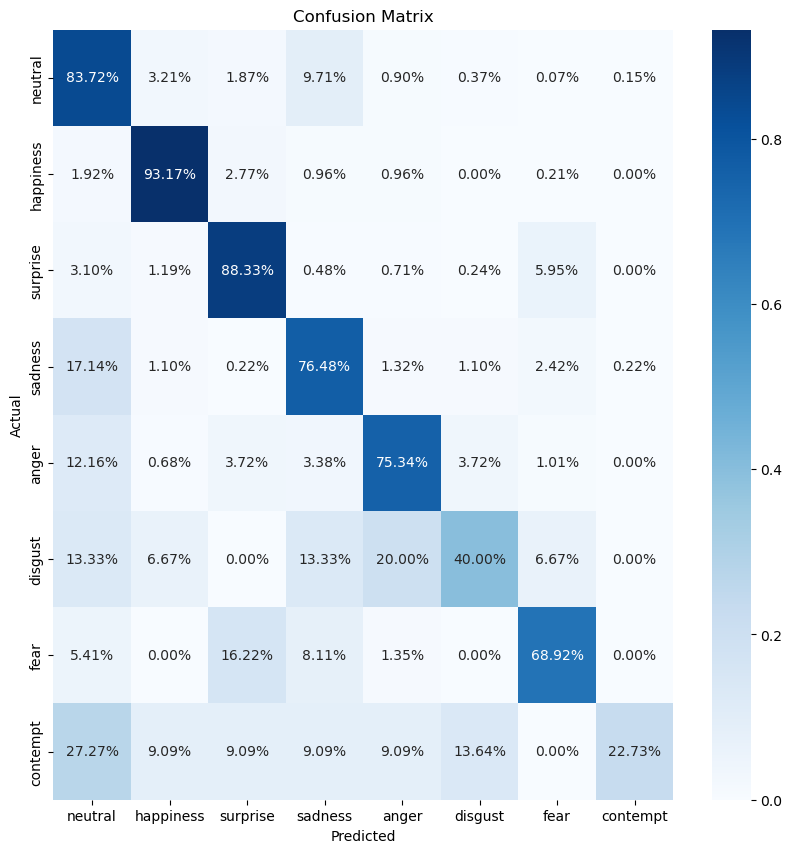

In [14]:
plot_confusion_matrix(predictions=predictions, targets=targets, class_names=class_names)

For reference, the confusion matrix in the paper https://arxiv.org/pdf/1608.01041.pdf is: 

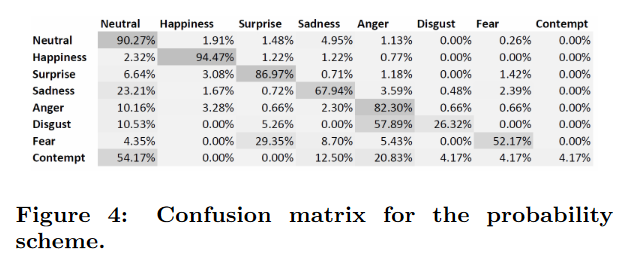